# ARESD Report Appendix

## NadirJalaludeen
## alan-man
## Sinan

In [1]:
import numpy as np #complex mathematical operations
import pandas as pd #using dataframes
import matplotlib.pyplot as plt #ploting graphs
import seaborn as sns #for the correlation heatmap
%matplotlib inline
import math #math

In [2]:
data = pd.read_csv("train.csv")

## 1 - seaborn Correlation Heatmap

<AxesSubplot:>

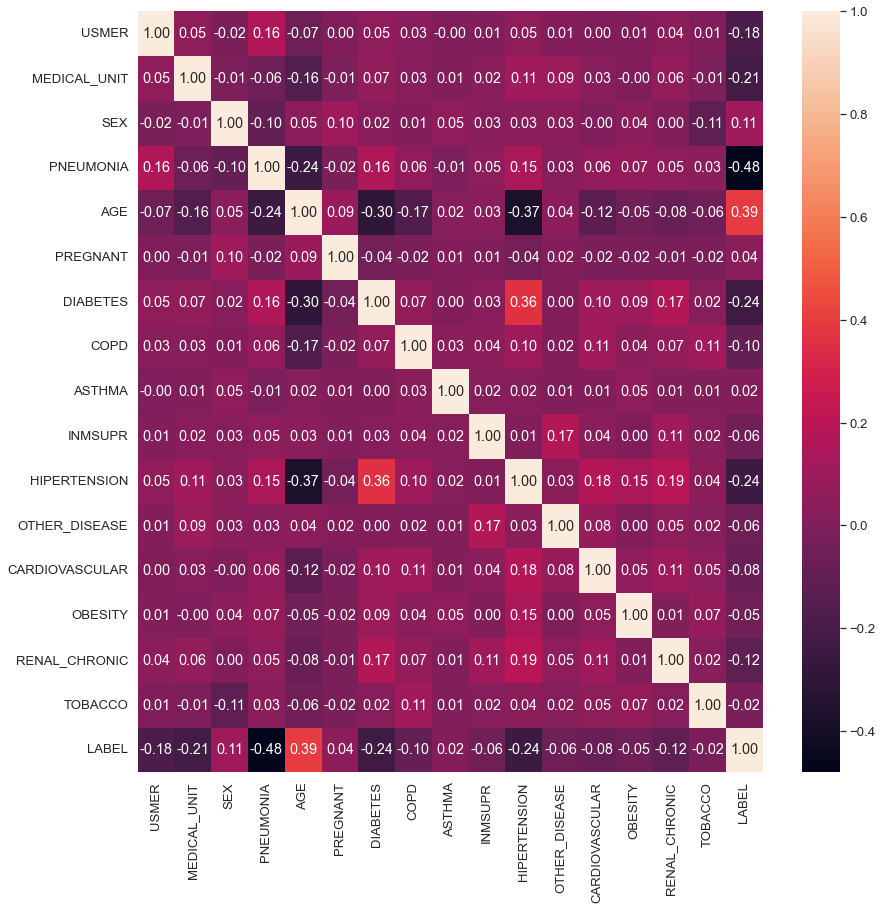

In [3]:
dataCorr = data

#Since the different values of LABEL are strings, we have to convert them to numerical values.
dataCorr["LABEL"] = [0 if l == "SOFT_COVID" else 1 if l == "STRONG_COVID" else 2 for l in data["LABEL"]]

#0 if the patient has Covid
#1 if the patient has a soft Covid
#2 if the patient has a strong Covid

sns.set(font_scale=1.20)
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data.corr(), annot = True, fmt='.2f', ax=ax)

In [4]:
#The preprocessed data, we get rid of the data that has a weak correlation with the Covid label:
dataClean = data[["USMER", "MEDICAL_UNIT","SEX","PNEUMONIA","AGE","DIABETES","HIPERTENSION","RENAL_CHRONIC"]]

## 2 - Split data function

In [5]:
def split_data(X, y, test_size):
    """Split our dataset in a test dataset and a train dataset
    Input: X & y should be numpy arrays"""
    
    #First, we create an array of length len(X) * (1-test_size) with random integer of [0;len(X)[ without allowing taking two times the same value
    train = np.random.choice(len(X), int(len(X) * (1-test_size)), replace=False)
    
    #Secondly, we extract the lines of corresponding index into an array
    X_train = np.array([X[i] for i in train])
    y_train = np.array([y[i] for i in train])
    
    #The test dataset will be extracted by finding the lines that were not in the first array
    X_test = np.array([X[i] for i in range(len(X)) if i not in train])
    y_test = np.array([y[i] for i in range(len(y)) if i not in train])
    return X_train, y_train, X_test, y_test

In [6]:
def folding(X, y, nb_part = 2):
    """Folding our dataset for cross-validation"""
    #First, we create an array of length len(X) with random integer of [0;len(X)[ without allowing taking two times the same value
    index = np.random.choice(len(y), len(y), replace=False)
    res = []
    
    #By using a for loop, we create a list of different test and train partitioning 
    for i in range(nb_part):
        test_index = index[int(i * len(y) / nb_part):int((i + 1) * len(y) / nb_part)]
        X_train = np.array([X[i] for i in range(len(X)) if i not in test_index])
        y_train = np.array([y[i] for i in range(len(y)) if i not in test_index])
        X_test = np.array([X[i] for i in test_index])
        y_test = np.array([y[i] for i in test_index])
        res.append((X_train, y_train, X_test, y_test))
    return res

## 3 - Random Forest Algorithm

In [7]:
def taux_bonne_classif(predictions, vrais_chiffres):
    """Find the accuracy of our model"""
    return len(predictions[predictions == vrais_chiffres]) / len(predictions)


def classe_majoritaire(label):
    """Find the majoritary label of a 1-D array"""
    #If there is no label, there is no label
    if len(label) == 0:
        return "No Label"
    valeurs, nb_fois = np.unique(label,return_counts=True)
    return valeurs[np.argmax(nb_fois)]


def shannon(p):
    """Return the entropy of a given 1-D array of probabilities"""
    if len(p) > 1:
        return -np.sum([i * np.log(i) for i in p if i > 0])/np.log(len(p))
    else:
        return -np.sum([i * np.log(i) for i in p if i > 0])

    
def entropy(ens):
    """Return the entropy of 1-D array of labels"""
    return shannon([len(ens[ens == i])/len(ens) for i in np.unique(ens)])


def information_gain(X, y, split_feature_idx, split_value):
    """Return the information gain of a certain split in our dataset"""
    y1 = y[X[:,split_feature_idx] <= split_value]
    y2 = y[X[:,split_feature_idx] > split_value]
    return entropy(y) - (len(y1)/len(y)) * entropy(y1) - (len(y2)/len(y)) * entropy(y2)


def predict(tree, x):
    """Return the label predicted by single tree recursively"""
    #If the node is a leaf node, return its value
    if not isinstance(tree, tuple):
        return tree
    
    #Else, extract the informations of the node, and evaluating the condition
    feature_idx, threshold, left_subtree, right_subtree = tree
    if x[feature_idx] <= threshold:
        return predict(left_subtree, x)
    else:
        return predict(right_subtree, x)


def bootstrap(X, y, oob = False):
    """Creates a bootstrapped dataset of the dataset"""
    #First, we create an array of length len(X) with random integer of [0;len(X)[ where we can take two times the same value
    bootstrap_list = np.random.randint(0, len(X), len(X))
    
    #Secondly, we extract the lines of corresponding index into an array
    X_bs = np.array([X[i] for i in bootstrap_list])
    y_bs = np.array([y[i] for i in bootstrap_list])
    
    #If we want an array of the oob data, we find them by searching for the values that are not in the bootstrapped dataset
    if oob:
        X_oob_index = np.array([i for i in range(len(X)) if i not in bootstrap_list])
        X_oob = np.array([X[i] for i in X_oob_index])
        return X_bs, y_bs, X_oob, X_oob_index
    
    return X_bs, y_bs


def find_best_split(X, y, nb_col=3):
    """Find the best split on the dataset to maximize the information gain"""
    #We first set some default values, in order to detect the best split
    best_gain = -1
    best_split_feature_idx = None
    best_split_value = None
    
    #We create an array of nb_col with random index representing the different columns
    #It will be the columns were we will look for the best split
    col = np.random.choice(X.shape[1], nb_col, replace=False)
    
    #We search the best split by testing every split possible
    for split_feature_idx in col:
        for split_value in np.unique(X[:, split_feature_idx]):
            gain = information_gain(X, y, split_feature_idx, split_value)
            if gain > best_gain:
                best_gain = gain
                best_split_feature_idx = split_feature_idx
                best_split_value = split_value
    
    return (best_split_feature_idx, best_split_value, best_gain)


def build_tree(X, y, nb_col=-1, max_depth=10, min_x_split=2):
    """Build a decision tree recursively
    Create a decision tree if nb_col = -1"""
    
    #Check if every label is the same
    if len(np.unique(y)) == 1:
        return y[0]
    
    #Check if we reached the maximum depth or there isn't enough data to split the node
    if (max_depth == 0) or (len(y) < min_x_split):
        return classe_majoritaire(y)
    
    #If we construct a regular tree, we have to consider every columns
    if nb_col < 1:
        nb_col = X.shape[1]
    
    #Find the best feature to split the data
    best_feature, best_value, best_gain = find_best_split(X, y, nb_col)
    
    #Check if there is no gain in splitting
    if best_gain == 0:
        return classe_majoritaire(y)
    
    #We create two arrays which indicates whether or not the split criteria is true or false
    left = X[:, best_feature] <= best_value
    right = X[:, best_feature] > best_value
    
    #We recursively create the left and right part of our node
    left_tree = build_tree(X[left], y[left], nb_col, max_depth - 1, min_x_split=2)
    right_tree = build_tree(X[right], y[right], nb_col, max_depth - 1, min_x_split=2)
    
    return (best_feature, best_value, left_tree, right_tree)


def build_forest(X, y, nb_col = 3, nb_tree=100, max_depth=10, min_x_split=2, oob=False):
    """Create a Random Forest
    Input: X & y should be numpy arrays
    Hyperparameters:
        -nb_col (int): number of columns that we should consider at each split
        -nb_tree (int): the number of tree that we want to construct
        -max_depth (int): the maximum depth of each tree
        -min_x_split (int): the minimum lenght of X to split the data
        -oob (bool): provides the oob accuracy"""
    
    forest = []
    
    #If we want the OOB
    if oob:
        
        #Initializing a list that will contain each prediction for each index
        oob_pred_list = [[] for i in range(len(X))]
        
        #Constructing nb_tree trees
        for i in range(nb_tree):
            X_bs, y_bs, X_oob, X_oob_index = bootstrap(X, y, True)
            tree = build_tree(X_bs, y_bs, nb_col, max_depth, min_x_split=2)
            forest.append(tree)
            
            #Prediction the OOB labels
            for j in range(len(X_oob_index)):
                oob_pred_list[X_oob_index[j]].append(predict(tree, X_oob[j]))
        
        #Calculating the OOB error
        oob_pred = np.array([classe_majoritaire(pred_list) for pred_list in oob_pred_list])
        print(taux_bonne_classif(oob_pred,y))
        return forest
    
    else:
        
        #Constructing nb_tree trees
        for i in range(nb_tree):
            X_bs, y_bs = bootstrap(X, y)
            tree = build_tree(X_bs, y_bs, nb_col, max_depth, min_x_split=2)
            forest.append(tree)
    return forest


def predict_forest(forest,x):
    """Predict the label of an input based on a forest"""
    votes = []
    for tree in forest:
        votes.append(predict(tree,x))
    return classe_majoritaire(votes)

## 4 - Final prediction

In [8]:
#Defining X & y
X = pd.read_csv("train.csv").iloc[:,:16].values
y = pd.read_csv("train.csv").iloc[:,16].values

#Setting the random seed
np.random.seed(42)

#Building the model
foret = build_forest(X, y, 9, 1000, 9, 6)

#Importing prev.csv
prev = pd.read_csv("prev.csv").iloc[:,1:].values

#Predicting and creating the submission file
prev_pred = np.array([predict_forest(foret,prev[i]) for i in range(len(prev))])
prediction = pd.DataFrame(np.column_stack((np.arange(0,len(prev_pred)),prev_pred)), columns = ["ID","LABEL"])
prediction.to_csv("Final_prediction.csv", index=False)
prediction

,ID,LABEL
0,0,DEAD
1,1,SOFT_COVID
2,2,STRONG_COVID
3,3,DEAD
4,4,STRONG_COVID
...,...,...
7507,7507,STRONG_COVID
7508,7508,STRONG_COVID
7509,7509,DEAD
7510,7510,DEAD


## Extra - Naive Bayes

#### Data Preprocessing

In [9]:
data = pd.read_csv("train.csv")


#Transforming the labels to numerical values
label = []
for i in range(len(data)):
    if data.iloc[i]["LABEL"] == "SOFT_COVID":
        label.append(1)
    elif data.iloc[i]["LABEL"] == "STRONG_COVID":
        label.append(2)
    elif data.iloc[i]["LABEL"] == "DEAD":
        label.append(3)
data["LABEL"] = label


#Splitting the dataset
np.random.seed(42)
train = np.random.choice(len(data), int(len(data) * (1-0.2)), replace=False)
test = np.array([i for i in range(len(data)) if i not in train])
dataTest = data.loc[test]
data = data.loc[train]
dataTest = (dataTest.reset_index()).iloc[:,1:]
data = (data.reset_index()).iloc[:,1:]

df = data.iloc[:,:16]
label = data["LABEL"]

df_test = dataTest.iloc[:,:16]
label_test = dataTest["LABEL"]

#### Model training

In [10]:
def frequency(data, column):
    return {i:len(data[data[column] == i])/len(data) for i in np.unique(data[column])}

fLabel = frequency(data, "LABEL")
fParLab = {labels:{par:frequency(df[label == labels], par) for par in df.columns} for labels in fLabel}
fParLab

{1: {'USMER': {1: 0.3375859912445278, 2: 0.6624140087554722},
  'MEDICAL_UNIT': {3: 0.022263914946841778,
   4: 0.300187617260788,
   5: 0.0061288305190744215,
   6: 0.038899312070043775,
   7: 0.0008755472170106316,
   8: 0.010631644777986242,
   9: 0.04040025015634772,
   10: 0.008630393996247656,
   11: 0.01125703564727955,
   12: 0.5599749843652283,
   13: 0.00075046904315197},
  'SEX': {1: 0.4881801125703565, 2: 0.5118198874296436},
  'PNEUMONIA': {1: 0.12382739212007504, 2: 0.8761726078799249},
  'AGE': {0: 0.0012507817385866166,
   1: 0.000375234521575985,
   2: 0.00012507817385866166,
   3: 0.0013758599124452783,
   4: 0.0012507817385866166,
   5: 0.0012507817385866166,
   6: 0.0008755472170106316,
   7: 0.0005003126954346467,
   8: 0.0012507817385866166,
   9: 0.0012507817385866166,
   10: 0.001876172607879925,
   11: 0.0012507817385866166,
   12: 0.00150093808630394,
   13: 0.0013758599124452783,
   14: 0.0028767979987492183,
   15: 0.00300187617260788,
   16: 0.0023764853033

#### Missing value estimation
Since some value are missing (like fParLab[1]["MEDICAL_UNIT"][2], and a lot of age)

In [11]:
def estimation(table):
    return (np.mean(table), np.var(table))

def loi_normale(x, mu, sigma2):
    return (1/((np.sqrt(sigma2) * np.sqrt(2*(np.pi)))) * np.exp(-((x - mu)**2)/(2 * sigma2)))

for labels in fLabel:
    mu, sigma2 = estimation(df[label == labels]["AGE"])
    for i in range(120):
        if i not in fParLab[labels]["AGE"]:
            fParLab[labels]["AGE"][i] = loi_normale(i, mu, sigma2)

fParLab[1]["MEDICAL_UNIT"][1] = 0
fParLab[1]["MEDICAL_UNIT"][2] = (fParLab[1]["MEDICAL_UNIT"][1] + fParLab[1]["MEDICAL_UNIT"][3])/2
fParLab[3]["MEDICAL_UNIT"][2] = (fParLab[3]["MEDICAL_UNIT"][1] + fParLab[3]["MEDICAL_UNIT"][3])/2

#### Testing our model

In [12]:
def classifier(pars, fParLab, fLab):
    res = {}
    for label in fLab:
        res[label] = 1
        for p in fParLab[label]:
            res[label] *= fParLab[label][p][pars[p]] * fLab[label]
    return max(res, key=res.get)

def taux_bonne_classif(predictions, vrais_chiffres):
    return len(predictions[predictions == vrais_chiffres]) / len(predictions)

test = dataTest.iloc[:,:16]
testPred = np.array([classifier(test.iloc[i], fParLab, fLabel) for i in range(len(test))])
taux_bonne_classif(testPred, label_test)

0.6511395774413575

#### Weighting the features

In [13]:
def classifier_weighted(pars, fParLab, fLab, weight):
    res = {}
    for label in fLab:
        res[label] = 1
        for p in fParLab[label]:
            res[label] *= fParLab[label][p][pars[p]]**weight[p] * fLab[label]
    return max(res, key=res.get)

def findWeight(train, trainLabel, fParLab, fLabel, pas, n_iter=15):
    pars = list(fParLab.values())[0]
    dicti = {p:1 for p in fParLab[1]}
    wt = dict()
    wt = {a:dicti[a] for a in dicti}
    w = dict()
    w = {a:dicti[a] for a in dicti}
    
    #Testing adding and removing a certain step at each features that decreases over the time
    #If the accuracy is better, the step is validated
    for it in range(0,n_iter):
        taux_debut = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, w) for i in range(len(train))]), trainLabel)
        for p in pars:
            wt[p] = wt[p] + pas
            taux_wt = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, wt) for i in range(len(train))]), trainLabel)
            taux_w = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, w) for i in range(len(train))]), trainLabel)
            if taux_wt > taux_w:
                w[p] = w[p] + pas
            else:
                wt[p] = wt[p] - pas
        for p in pars:
            wt[p] = wt[p] - pas
            taux_wt = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, wt) for i in range(len(train))]), trainLabel)
            taux_w = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, w) for i in range(len(train))]), trainLabel)
            if taux_wt > taux_w:
                w[p] = w[p] - pas
            else:
                wt[p] = wt[p] + pas
                
        taux_fin = taux_bonne_classif(np.array([classifier_weighted(train.iloc[i], fParLab, fLabel, w) for i in range(len(train))]), trainLabel)
        
        #Print the progression
        print(str(it + 1) + "/" + str(n_iter) + " | Step used : " + str(pas) +" | Accuracy: " + str(taux_fin))
        
        #Decreasing the step
        if taux_fin == taux_debut:
            pas = pas/2
            
    return w

In [14]:
poids = findWeight(df, label, fParLab, fLabel, 0.4, 12)

1/12 | Step used : 0.4 | Accuracy: 0.6699667221297837
2/12 | Step used : 0.4 | Accuracy: 0.6728369384359401
3/12 | Step used : 0.4 | Accuracy: 0.6731697171381031
4/12 | Step used : 0.4 | Accuracy: 0.6735440931780367
5/12 | Step used : 0.4 | Accuracy: 0.6735440931780367
6/12 | Step used : 0.2 | Accuracy: 0.6736688851913477
7/12 | Step used : 0.2 | Accuracy: 0.6740016638935108
8/12 | Step used : 0.2 | Accuracy: 0.6742096505823627
9/12 | Step used : 0.2 | Accuracy: 0.6742096505823627
10/12 | Step used : 0.1 | Accuracy: 0.6743344425956739
11/12 | Step used : 0.1 | Accuracy: 0.6743344425956739
12/12 | Step used : 0.05 | Accuracy: 0.6743344425956739


In [15]:
poids

{'USMER': 1.4,
 'MEDICAL_UNIT': 1.4,
 'SEX': 1,
 'PNEUMONIA': 1.4,
 'AGE': 1.4,
 'PREGNANT': 0.7,
 'DIABETES': -0.20000000000000007,
 'COPD': -0.4000000000000001,
 'ASTHMA': 0.6,
 'INMSUPR': 1,
 'HIPERTENSION': 0.19999999999999996,
 'OTHER_DISEASE': 1.5999999999999999,
 'CARDIOVASCULAR': 0.19999999999999996,
 'OBESITY': 1,
 'RENAL_CHRONIC': 1,
 'TOBACCO': 1.4}

In [17]:
testPred = np.array([classifier_weighted(test.iloc[i], fParLab, fLabel, poids) for i in range(len(test))])
taux_bonne_classif(testPred, label_test)

0.6729329562468808